In [1]:
from collections import defaultdict
import json
import math
import gdown
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import sys
import matplotlib.colors as mcolors

# Adjust display format for pandas
pd.options.display.float_format = '{:.2f}'.format

# Add parent directory to system path
notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
sys.path.append(os.path.join(parent_dir, 'core'))

# Import from core directory
from algorithms import GD, LogisticModel

In [2]:
# Load models, X, Y, and datetimes to a file
data = np.load('./.cache/models_X_Y.npz', allow_pickle=True)
models, X, Y, datetimes = data['models'], data['X'], data['Y'], data['datetimes']

truncate = 50000
X = X[-truncate:]
Y = Y[-truncate:]
datetimes = datetimes[-truncate:]

# Subset to only the models with battles
idx_nonzero = np.abs(X).sum(axis=0) > 0

X = X.T[idx_nonzero].T
models = models[idx_nonzero]

In [3]:
T = X.shape[0]
d = X.shape[1]
device = "cpu"
lrs = [0, 0.01, 0.1, 1]
experiment_name = "vanilla"

In [4]:
df_list = []
for lr in lrs:
    # Initialize the simple model
    model = LogisticModel(torch.zeros((d,)))

    # Define the mean squared error loss
    loss_fn = nn.BCELoss(reduction='sum')

    # Initialize the Gradient Descent optimizer
    optimizer = GD(model.parameters(), lr=lr)

    # Training loop
    thetas = torch.zeros(T+1, d, dtype=torch.float32)
    ys = torch.zeros(T+1, dtype=torch.float32)
    yhats = torch.zeros(T+1, dtype=torch.float32)
    losses = torch.zeros(T+1, dtype=torch.float32)
    gradients = torch.zeros(T+1, d, dtype=torch.float32)
    average_losses = torch.zeros(T+1, dtype=torch.float32)
    average_gradients = torch.zeros(T+1, d, dtype=torch.float32)
    model_a = [None, ]
    model_b = [None, ]

    model = model.to(device)

    for t in tqdm(range(T)):
        # Set up data
        x_t = torch.tensor(X[t], dtype=torch.float32)
        y_t = torch.tensor(Y[t], dtype=torch.float32)

        # Perform optimization
        optimizer.zero_grad()
        thetas[t+1] = model.theta.detach().cpu()
        prediction = model(x_t.to(device))
        loss = 0.5*loss_fn(prediction.squeeze(), y_t.to(device).squeeze())
        loss.backward()
        optimizer.step()

        # Store results
        ys[t+1] = y_t.detach().cpu()
        yhats[t+1] = prediction
        losses[t+1] = loss.detach().cpu().item()
        gradients[t+1] = model.theta.grad.detach().cpu()
        average_gradients[t+1] = gradients[:t+1].mean(dim=0)
        average_losses[t+1] = losses[:t+1].mean()
        model_a += [models[np.where(x_t==-1)[0][0]]]
        model_b += [models[np.where(x_t==1)[0][0]]]
        
    # Cache the thetas, ys, gradients, and norms in a pandas dictionary
    os.makedirs('.cache/' + experiment_name, exist_ok=True)
    df = pd.DataFrame({
        'theta': thetas.tolist(), 
        'y': ys.tolist(), 
        'yhat': yhats.tolist(), 
        'loss' : losses.tolist(), 
        'gradient': gradients.tolist(), 
        'average gradient': average_gradients.tolist(), 
        'average loss' : average_losses.tolist(),
        'model_a': model_a,
        'model_b': model_b
    })
    df.loc[1:,"datetime"] = datetimes

    df['lr'] = float(lr)
    df['d'] = d
    df_list += [df]

df = pd.concat(df_list, ignore_index=True)
df['norm of avg grad'] = df['average gradient'].apply(np.linalg.norm, ord=np.inf)
df.to_pickle('.cache/' + experiment_name + '/' + "0" + '.pkl')

100%|██████████| 50000/50000 [00:58<00:00, 857.21it/s] 


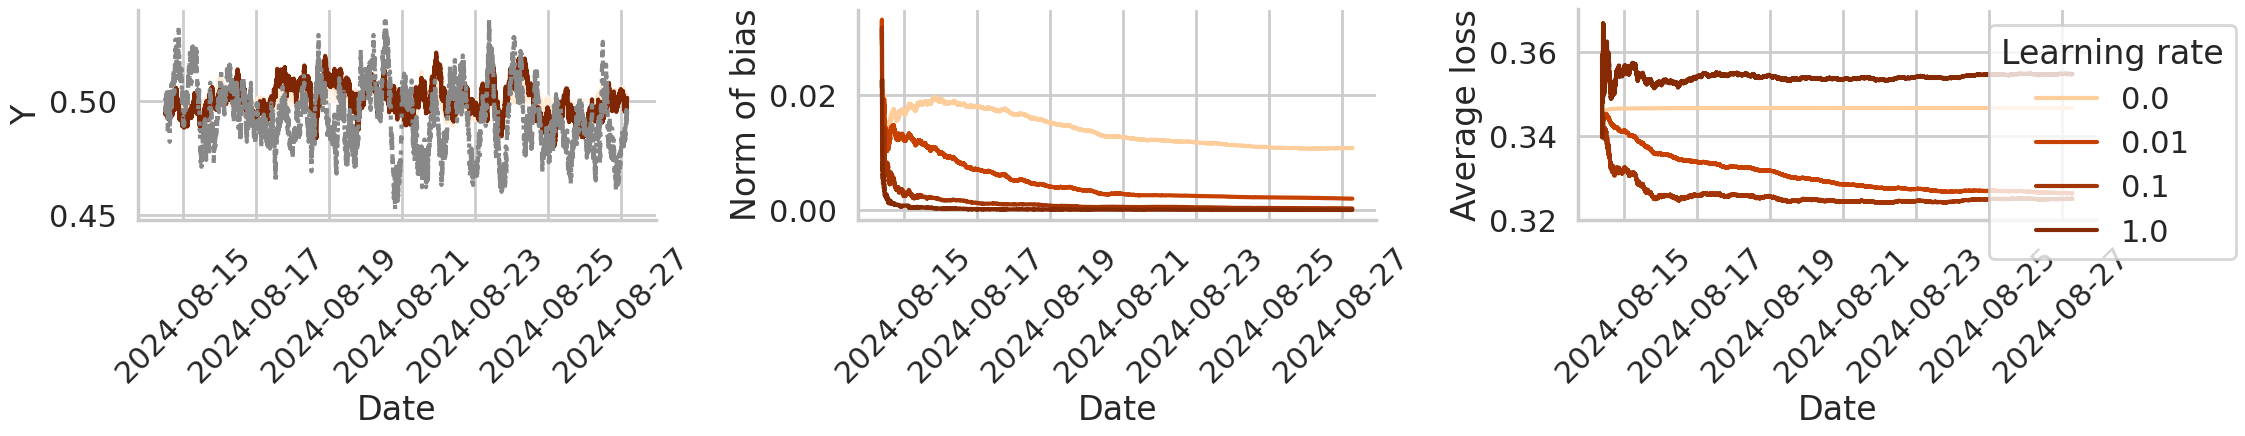

In [6]:
# Add burnin variable
burnin = 50  # Adjust this value as needed

# Create color map
lr_cmap = plt.cm.Oranges

# Use logarithmic normalization
# This ensures equal color spacing on a log scale
eps = 1e-8
norm = mcolors.LogNorm(vmin=min(np.array(lrs)+eps)/1000, vmax=max(np.array(lrs)+eps)*2)

# Create the colors by mapping the learning rates to the colormap
hues = {
    lr: lr_cmap(norm(lr+eps)) for lr in lrs
}

os.makedirs('./plots/' + experiment_name, exist_ok=True)

sns.set_style("whitegrid")
sns.set_context("poster")
sns.set_palette("pastel")

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(23,5), sharex=True, sharey=False)
window_size = 1000
# Apply burnin to the dataframe
df_plot = df[df.datetime >= df[df.lr == 0].datetime.nsmallest(burnin).iloc[-1]]

# First, plot the ys, fs, and yhats on the same plot, to visually check the predictions.
# Predictions for each learning rate (plot these first)
pred_df = df_plot.copy()
pred_df['yhat_rolling'] = pred_df.groupby('lr')['yhat'].transform(
    lambda x: x.rolling(window=window_size, center=True).mean()
)
_lp = sns.lineplot(ax=axs[0], data=pred_df,
                  x="datetime", y="yhat_rolling",
                  hue="lr", palette=lr_cmap,
                  estimator=None, n_boot=0,
                  hue_order=lrs)

# True values (plot these last so they appear on top)
true_df = df_plot[df_plot.lr == 0].copy()
true_df['y_rolling'] = true_df['y'].rolling(window=window_size, center=True).mean()
sns.lineplot(ax=axs[0], data=true_df,
            x="datetime", y="y_rolling", color="#888888",
            estimator=None, n_boot=0, label="True Values",
            linestyle=":", zorder=10)  # Higher zorder ensures it's drawn on top

axs[0].set_ylabel("Y")
_lp.get_legend().remove()


# Next, plot the average gradient over time
_lp = sns.lineplot(ax=axs[1], data=df_plot, x="datetime", y="norm of avg grad", hue="lr", palette=hues, estimator=None, n_boot=0)
_lp.get_legend().remove()
axs[1].set_ylabel("Norm of bias")

# Next, plot the average loss over time
_lp = sns.lineplot(ax=axs[2], data=df_plot, x="datetime", y="average loss", hue="lr", palette=hues, estimator=None, n_boot=0)
_lp.get_legend().set_loc('upper right')
axs[2].set_ylabel("Average loss")
axs[2].legend(loc="upper right", bbox_to_anchor=(1.3,1), title='Learning rate')

for tick in axs[0].get_xticklabels() + axs[1].get_xticklabels() + axs[2].get_xticklabels():
    tick.set_rotation(45)  # adjust the rotation angle as needed

sns.despine(top=True, right=True)

for ax in axs:
    ax.set_xlabel("Date")

ylims_avg_grad_1 = axs[1].get_ylim()
axs[2].set_ylim([0.32, 0.37])


plt.tight_layout()

plt.savefig('./plots/' + experiment_name + "/" + "series_with_burnin.pdf")
plt.show()

/tmp/ipykernel_2164737/663853472.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_cycle = plt.cm.get_cmap('Set1')(np.linspace(0, 1, len(idxs_to_plot)))


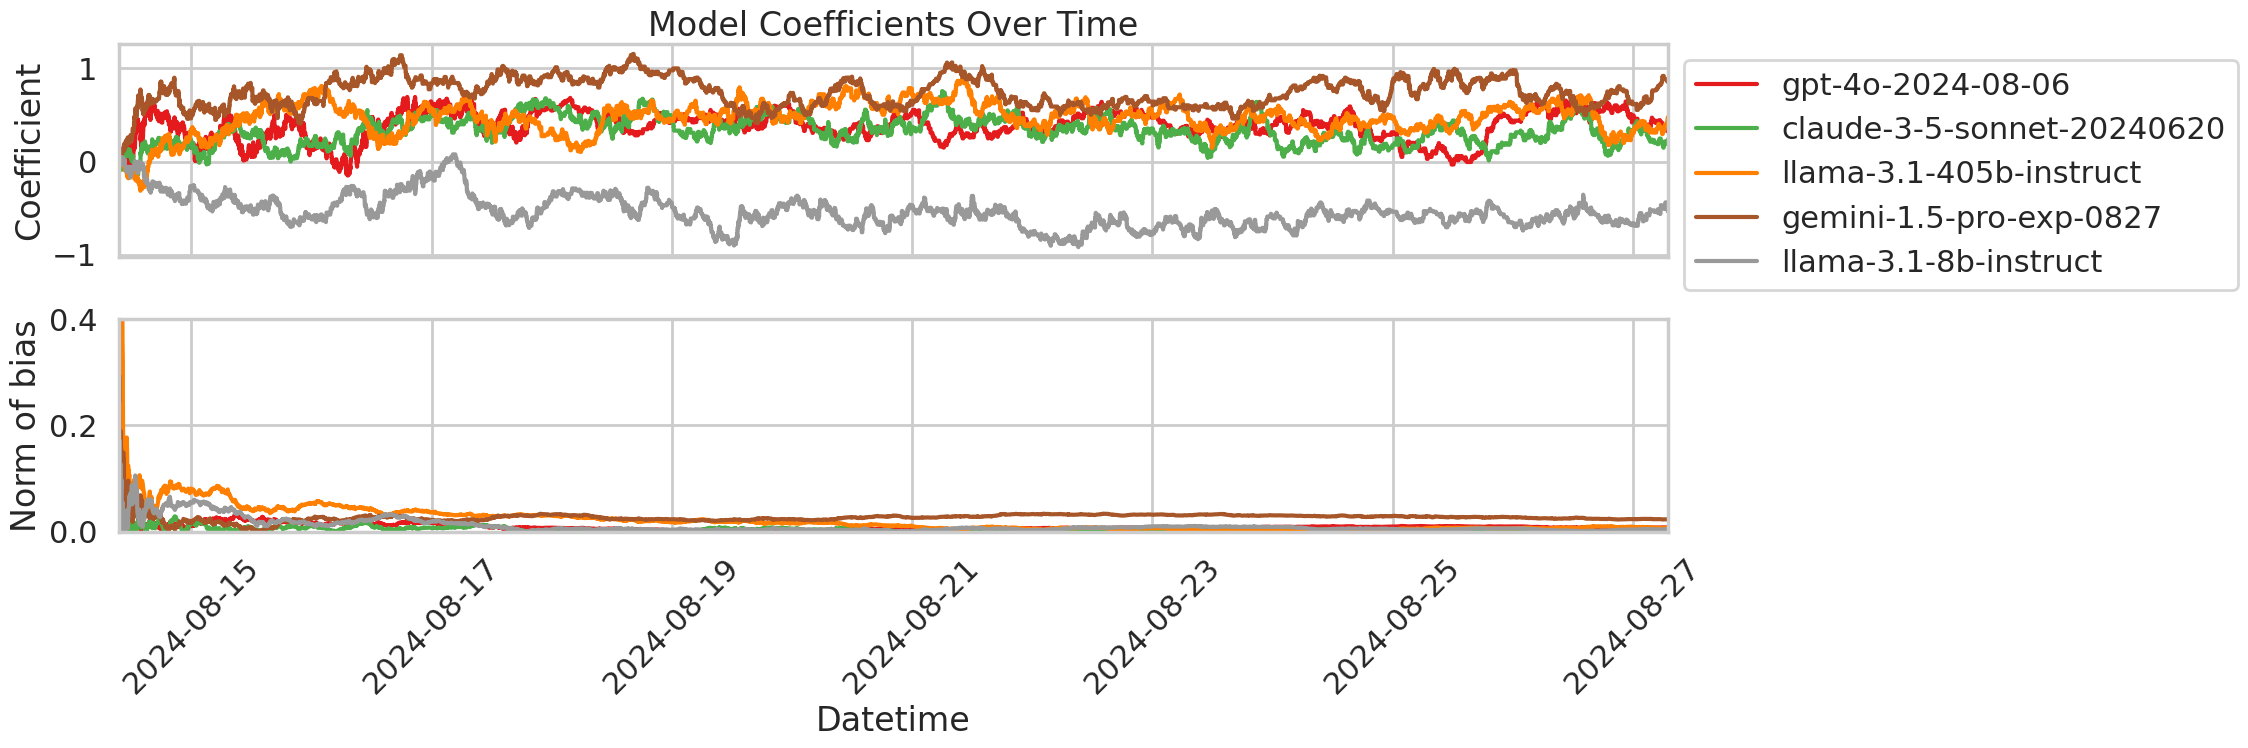

In [21]:
models_to_plot = [
    'gpt-4o-2024-08-06',
     'claude-3-5-sonnet-20240620',
     'llama-3.1-405b-instruct',
     'gemini-1.5-pro-exp-0827',
     'llama-3.1-8b-instruct'
]


# Filter for lr=0.1
df_filtered = df[df.lr == 0.1]

idxs_to_plot = [
    np.where(models == m)[-1][0] for m in models_to_plot
]

# Set up the plot
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(23, 8), sharex=True)

# Color cycle for different models
color_cycle = plt.cm.get_cmap('Set1')(np.linspace(0, 1, len(idxs_to_plot)))

# Plot coefficients for each of the models
for i, model_idx in enumerate(idxs_to_plot):
    # Extract coefficients for this model
    coefficients = df_filtered.theta.apply(lambda x : x[model_idx])
    
    # Plot each coefficient
    axs[0].plot(df_filtered['datetime'], coefficients, 
                label=f'{models[model_idx]}', 
                color=color_cycle[i], 
                linestyle='-')  # Cycle through line styles
    for tick in plt.gca().get_xticklabels():
        tick.set_rotation(45)  # adjust the rotation angle as needed

axs[0].set_ylabel('Coefficient')
axs[0].set_title('Model Coefficients Over Time')
axs[0].set_xlabel('')
axs[0].legend(bbox_to_anchor=(1., 1), loc='upper left')
axs[0].set_xlim([df_filtered.datetime.min(), df_filtered.datetime.max()])


# Get the per-model bias
for i, model_idx in enumerate(idxs_to_plot):
    # Extract df for this model
    per_model_df = df_filtered[(df_filtered["model_a"] == models_to_plot[i]) | (df_filtered["model_b"] == models_to_plot[i])]
    # Plot bias
    axs[1].plot(per_model_df['datetime'], (per_model_df["yhat"]-per_model_df["y"]).expanding().mean().abs(), 
                label=f'{models[model_idx]}', 
                color=color_cycle[i], 
                linestyle='-')  # Cycle through line styles
    for tick in plt.gca().get_xticklabels():
        tick.set_rotation(45)  # adjust the rotation angle as needed

axs[1].set_ylabel('Norm of bias')
axs[1].set_xlabel('Datetime')
axs[1].set_ylim([0,0.4])
plt.tight_layout()

# Save the plot
plt.savefig('./plots/' + experiment_name + "/" + "elos.pdf", bbox_inches="tight")
plt.show()